In [1]:
import h5py
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from ZOO_lightning import LitNeuralNet

DTYPE = torch.float32
DEVICE = 'mps:0'

/Users/davidchemaly/miniforge3/envs/Torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: davidchemaly. Use `wandb login --relogin` to force relogin


In [4]:
SEED = 42
DATA_PATH = '/Volumes/ES-HDD-Documents/Documents/matlas_dwarfs/NGC5473_224_patches_NO-Overlap_qty100.h5'
WEIGHTS_PATH = './effnetb0_color_224px.ckpt'

# CHECKPOINT_PATH = './ZOO-e100-lr0.0003-bs2-seed42/ZOO-epoch=11-train_loss=0.0171-valid_loss=0.0088.ckpt'
CHECKPOINT_PATH = './ZOO-e100-lr0.0003-bs2-seed42-ONE_channel/ZOO-epoch=96-train_loss=0.0133-valid_loss=0.0408.ckpt'


In [5]:
# Load the Data
arg_valid       = np.loadtxt(f'arg_valid_seed{SEED}_stratify.txt').astype(int)
# arg_interesting = np.loadtxt('arg_interesting.txt').astype(int)
arg_interesting = np.loadtxt('arg_interesting_NO-Overlap.txt').astype(int)

with h5py.File(DATA_PATH, 'r') as f:
    patches_rgi   = np.arcsinh(f['data'][arg_valid[arg_interesting]]) 
    patches_dwarf = f['dwarf'][arg_valid[arg_interesting]] 
patches_binary = (np.sum( patches_dwarf, axis=(1,2,3) ) != 0).astype(int)

OSError: [Errno 16] Unable to synchronously open file (file read failed: time = Wed Apr 24 21:27:50 2024
, filename = '/Volumes/ES-HDD-Documents/Documents/matlas_dwarfs/NGC5473_224_patches_NO-Overlap_qty100.h5', file descriptor = 78, errno = 16, error message = 'Resource busy', buf = 0x16d3a9260, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

In [17]:
# Load the Model
ZOO_model = timm.create_model('efficientnet_b0', pretrained=False)

# Load the state dict from the .ckpt file
original_state_dict = torch.load(WEIGHTS_PATH, map_location=torch.device('cpu'))['state_dict']

adjusted_state_dict = {}
for key, value in original_state_dict.items():
    if key.startswith('encoder.'):
        adjusted_state_dict[key.replace('encoder.', '')] = value
    if key.startswith('head.1.0.'):
        adjusted_state_dict[key.replace('head.1.0.', 'classifier.')] = value
adjusted_state_dict.pop('classifier.weight', None)
adjusted_state_dict.pop('classifier.bias', None)

ZOO_model.load_state_dict(adjusted_state_dict, strict=False)

model = LitNeuralNet.load_from_checkpoint(checkpoint_path=CHECKPOINT_PATH, ZOO_model=ZOO_model)
model.eval();

Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ZOO-e100-lr0.0003-bs2-seed42-ONE_channel/ZOO-epoch=96-train_loss=0.0133-valid_loss=0.0408.ckpt`


In [18]:
y_pred = model.forward(torch.tensor(patches_rgi).to(DTYPE))
probs  = torch.sigmoid(y_pred.squeeze())  
preds  = np.array((probs > 0.5).long().long().detach().cpu())

In [19]:
arg_TP = np.where( patches_binary * preds == 1)[0]
arg_FP = np.where( (1-patches_binary) * preds == 1)[0]
arg_FN = np.where( patches_binary * (1-preds) == 1)[0]
print(len(arg_TP), len(arg_FP), len(arg_FN))

3 7 2


In [29]:
def saliency_map(arr, model):
    X = torch.tensor(arr).to(DTYPE)
    X.requires_grad_()

    scores = model(X)
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]

    score_max.backward()

    saliency, _ = torch.max(X.grad.data.abs(),dim=1)

    return saliency[0].detach().numpy()

True Positives


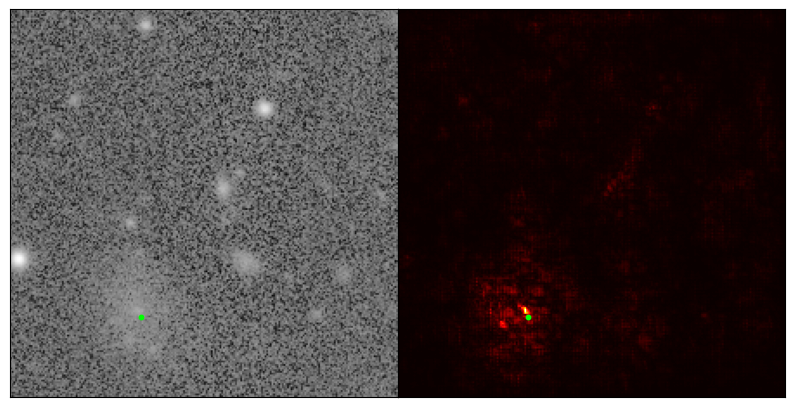

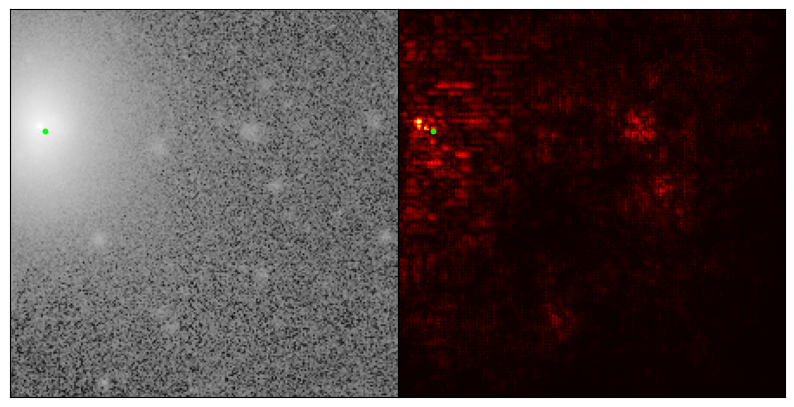

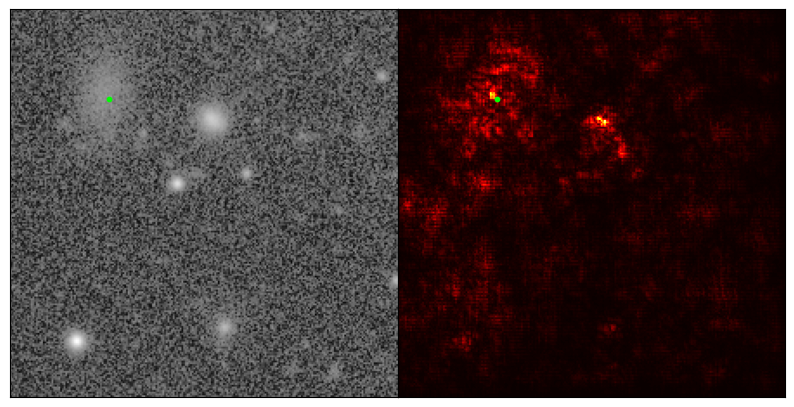

In [106]:
print('True Positives')

arg_data = arg_TP

for i in range(len(arg_data)):

    fig, axs = plt.subplots(1, 2, figsize=(10, 10), gridspec_kw = {'wspace':0, 'hspace':0})

    axs[0].imshow(patches_rgi[arg_data[i], 0].T, cmap='grey')
    xd, yp = np.where( patches_dwarf[arg_data[i], 0] == 1)
    axs[0].scatter(xd, yp, c='lime', s=10)

    axs[1].imshow(saliency_map( patches_rgi[arg_data[i]][None], model).T , cmap=plt.cm.hot)
    axs[1].scatter(xd, yp, c='lime', s=10)


    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])

False Positives


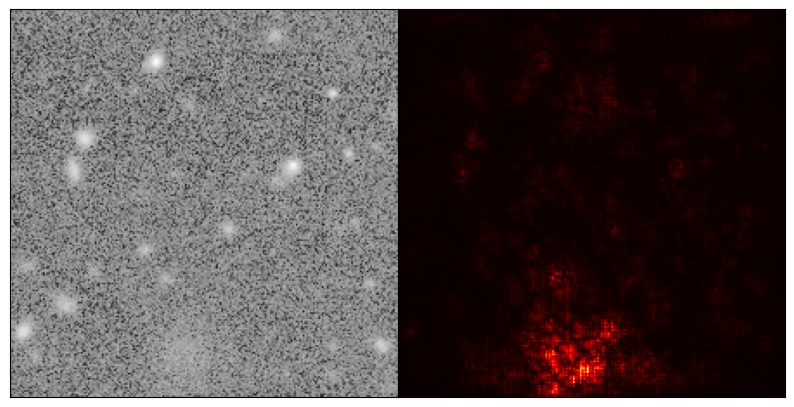

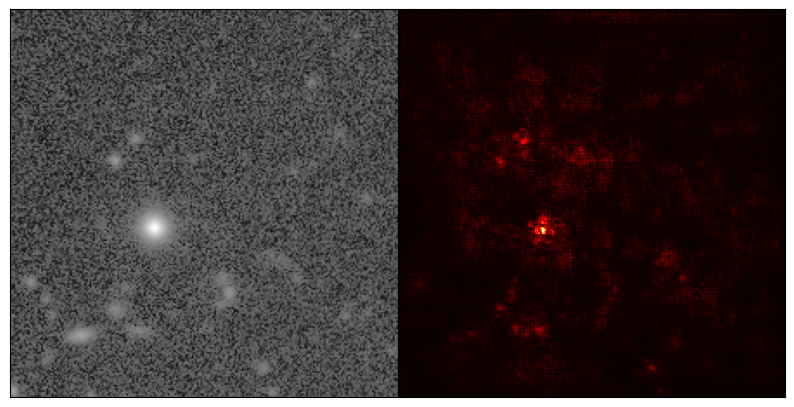

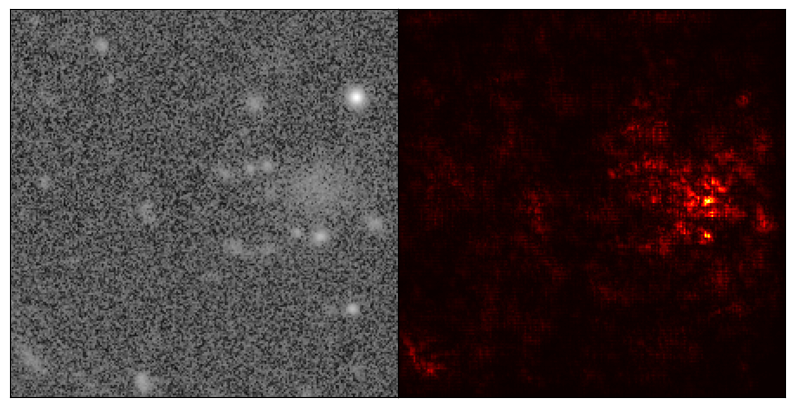

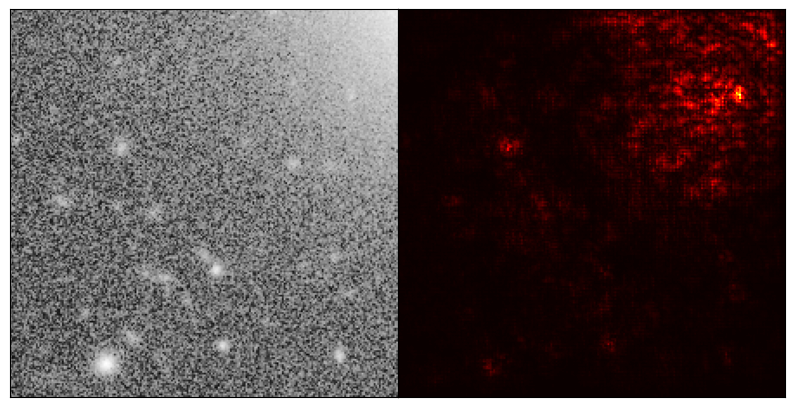

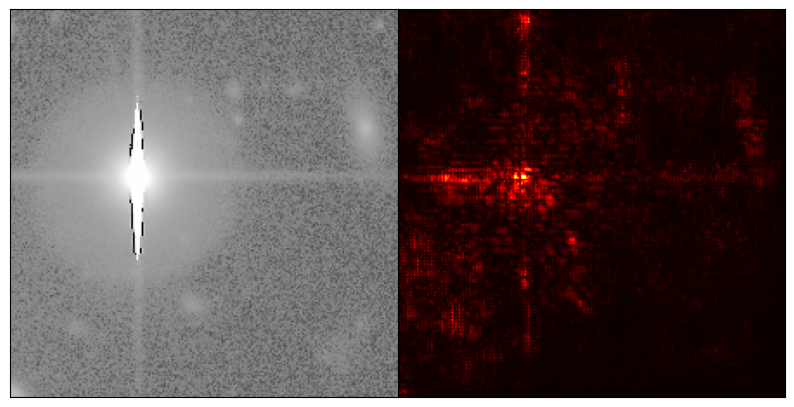

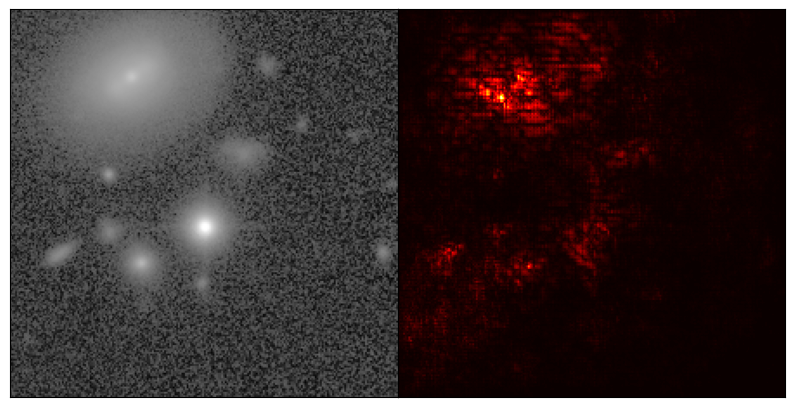

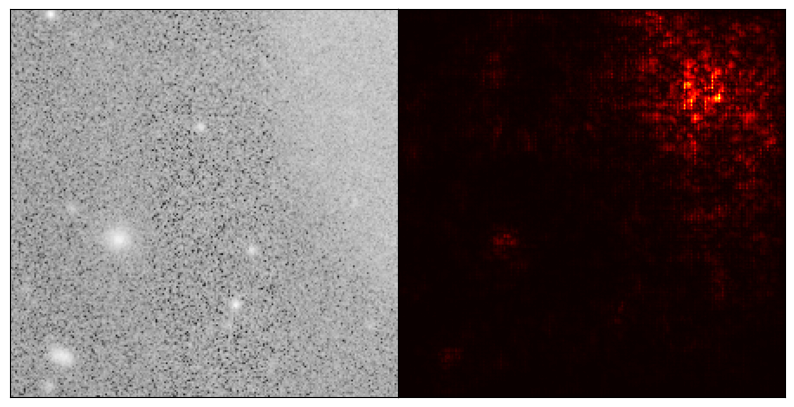

In [108]:
print('False Positives')

arg_data = arg_FP

for i in range(len(arg_data)):

    fig, axs = plt.subplots(1, 2, figsize=(10, 10), gridspec_kw = {'wspace':0, 'hspace':0})

    axs[0].imshow(patches_rgi[arg_data[i], 0].T, cmap='grey')
    xd, yp = np.where( patches_dwarf[arg_data[i], 0] == 1)
    axs[0].scatter(xd, yp, c='lime', s=10)

    axs[1].imshow(saliency_map( patches_rgi[arg_data[i]][None], model).T , cmap=plt.cm.hot)
    axs[1].scatter(xd, yp, c='lime', s=10)


    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])

False Negatives


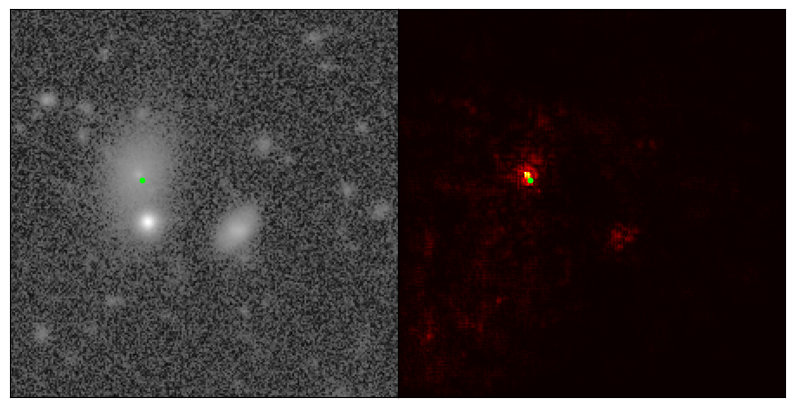

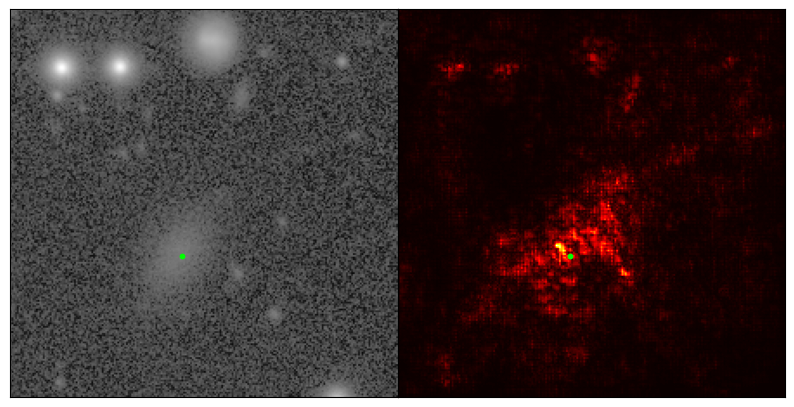

In [109]:
print('False Negatives')

arg_data = arg_FN

for i in range(len(arg_data)):

    fig, axs = plt.subplots(1, 2, figsize=(10, 10), gridspec_kw = {'wspace':0, 'hspace':0})

    axs[0].imshow(patches_rgi[arg_data[i], 0].T, cmap='grey')
    xd, yp = np.where( patches_dwarf[arg_data[i], 0] == 1)
    axs[0].scatter(xd, yp, c='lime', s=10)

    axs[1].imshow(saliency_map( patches_rgi[arg_data[i]][None], model).T , cmap=plt.cm.hot)
    axs[1].scatter(xd, yp, c='lime', s=10)

    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])